##### Copyright 2020 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## Guided Evolutionary Strategies Demo (using Jax)

Date: 06/08/2020

This is a self-contained notebook that reproduces the toy example in Fig. 1 of the [Guided ES](https://arxiv.org/abs/1806.10230) paper.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
from jax.experimental import optimizers

print(f'Jax version: {jax.__version__}')

Jax version: 0.1.69


### Problem setup

We test the algorithms on a toy problem where we explicitly add bias and variance to the gradient.

In [3]:
# Generate problem data.
rs = np.random.RandomState(seed=0)
m = 2000  # Number of data points.
n = 1000  # Number of variables.

A = rs.randn(m, n)
b = rs.randn(m, 1)

xstar = np.linalg.lstsq(A, b, rcond=None)[0]
f_star = (0.5/float(m)) * np.linalg.norm(np.dot(A, xstar) - b) ** 2

A = jnp.array(A)
b = jnp.array(b)

def l2_normalize(vector):
    return vector / jnp.linalg.norm(vector)

# This is a bias vector that will be added to the gradient
grad_bias = 1.0 * l2_normalize(jnp.array(rs.randn(n, 1)))

def loss_and_grad_fun(x):
    residual = jnp.dot(A, x) - b
    loss = 0.5 * jnp.linalg.norm(residual) ** 2 / float(m)
    
    # The 'gradient' that we observe is a noisy, biased version of the true gradient.
    # This is meant to mimic scenarios where we only have access to biased gradients.
    err = jnp.dot(A.T, residual) / float(m)
    gradient = err + grad_bias * jnp.linalg.norm(err)
    
    return loss, gradient

/Users/nirum/anaconda3/lib/python3.7/site-packages/jax/lib/xla_bridge.py:127: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


### Algorithm 1: Gradient Descent

Our first algorithm is gradient descent, applied directly to the biased gradients.

In [4]:
init_opt, update_opt, get_params = optimizers.sgd(5e-3)

@jax.jit
def step_fun(step, opt_state):
    x = get_params(opt_state)
    loss, gradient = loss_and_grad_fun(x)
    opt_state = update_opt(step, gradient, opt_state)
    return loss, opt_state

In [5]:
%%time

x = jnp.zeros((n, 1))
opt_state = init_opt(x)

fobj = []
for step in range(10000):
    loss, opt_state = step_fun(step, opt_state)
    fobj.append(loss)
    
# Store training curve for plotting later.
f_gd = np.array(fobj).copy()

CPU times: user 12.7 s, sys: 981 ms, total: 13.7 s
Wall time: 12.6 s


### Algorithm 2: Vanilla Evolutionary Strategies (Vanilla ES)

Our next algorithm is vanilla (standard) evolutionary strategies. This is a zeroth-order optimization algorithm, which means that it only uses the function evaluation (and ignores the biased gradients).

In [6]:
# Hyperparameters for Vanilla ES
sigma = 0.1
beta = 1.0
learning_rate = 0.2

# Defines the distribution for sampling parameter perturbations.
scale = sigma / np.sqrt(n)
def sample(prng_key):
    return scale * jax.random.normal(prng_key, shape=(n, 1))

init_opt, update_opt, get_params = optimizers.sgd(0.2)
base_key = jax.random.PRNGKey(0)

@jax.jit
def step_fun(step, opt_state):
    prng_key = jax.random.fold_in(base_key, step)
    epsilon = sample(prng_key)
    
    x = get_params(opt_state)
    
    # We utilize antithetic (positive and negative) samples.
    f_pos, _ = loss_and_grad_fun(x + epsilon)
    f_neg, _ = loss_and_grad_fun(x - epsilon)
    
    # This update is a stochastic finite difference estimate of the true gradient.
    update = (beta / (2 * sigma ** 2)) * (f_pos - f_neg) * epsilon
    opt_state = update_opt(step, update, opt_state)
    
    return loss_and_grad_fun(x)[0], opt_state

In [7]:
%%time

x = jnp.zeros((n, 1))
opt_state = init_opt(x)

# Run the optmizer.
fobj = []
for step in range(10000):
    loss, opt_state = step_fun(step, opt_state)
    fobj.append(loss)

# Store training curve for plotting later.
f_ves = np.array(fobj).copy()

CPU times: user 19.8 s, sys: 1.55 s, total: 21.4 s
Wall time: 24.2 s


### Algorithm 3: Guided Evolutionary Strategies (Guided ES)

Guided ES is our proposed method. It uses a diagonal plus low-rank covariance matrix for drawing perturbations, where the low-rank subspace is spanned by the available gradient information.

This allows it to incorporate the biased gradient information, while still minimizing the true loss function.

In [8]:
# Hyperparameters for Guided ES
sigma = 0.1
alpha = 0.5
beta = 1.0
k = 1        # Defines the dimensionality of the low-rank subspace.

# Defines parameters of the distribution for sampling perturbations.
a = sigma * np.sqrt(alpha / float(n))
c = sigma * np.sqrt((1. - alpha) / float(k))

# Defines the distribution for sampling parameter perturbations.
def sample(prng_key, gradient_subspace):
    keys = jax.random.split(prng_key, 2)
    
    epsilon_full = jax.random.normal(keys[0], shape=(n, 1))
    epsilon_subspace = jax.random.normal(keys[1], shape=(k, 1))
    
    Q, _ = jnp.linalg.qr(gradient_subspace)
    epsilon = a * epsilon_full + c * jnp.dot(Q, epsilon_subspace)
    
    return epsilon

init_opt, update_opt, get_params = optimizers.sgd(0.2)
base_key = jax.random.PRNGKey(0)

@jax.jit
def step_fun(step, opt_state):
    prng_key = jax.random.fold_in(base_key, step)
    
    x = get_params(opt_state)
    loss, gradient = loss_and_grad_fun(x)
    epsilon = sample(prng_key, gradient)

    # We utilize antithetic (positive and negative) samples.
    f_pos, _ = loss_and_grad_fun(x + epsilon)
    f_neg, _ = loss_and_grad_fun(x - epsilon)
    
    # This update is a stochastic finite difference estimate of the true gradient.
    update = (beta / (2 * sigma ** 2)) * (f_pos - f_neg) * epsilon
    opt_state = update_opt(step, update, opt_state)
    
    return loss, opt_state

In [9]:
%%time

x = jnp.zeros((n, 1))
opt_state = init_opt(x)

# Run the optmizer.
fobj = []
for step in range(10000):
    loss, opt_state = step_fun(step, opt_state)
    fobj.append(loss)

# Store training curve for plotting later.
f_ges = np.array(fobj).copy()

CPU times: user 35.9 s, sys: 1.7 s, total: 37.6 s
Wall time: 22.5 s


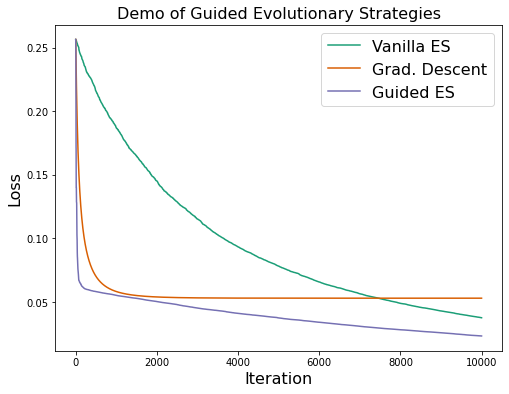

In [10]:
COLORS = {'ges': '#7570b3', 'ves': '#1b9e77', 'sgdm': '#d95f02'}
plt.figure(figsize=(8, 6))
plt.plot(f_ves - f_star, color=COLORS['ves'], label='Vanilla ES')
plt.plot(f_gd - f_star, color=COLORS['sgdm'], label='Grad. Descent')
plt.plot(f_ges - f_star, color=COLORS['ges'], label='Guided ES')
plt.legend(fontsize=16, loc=0)
plt.xlabel('Iteration', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.title('Demo of Guided Evolutionary Strategies', fontsize=16);